# Task 4: Modular Modeling and Pricing

This notebook uses the modular code in src/modeling.py for claim severity prediction, claim probability modeling, and premium optimization.


In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
import pandas as pd
import numpy as np
from src.modeling import DataPreparer, ClaimSeverityModel, ClaimProbabilityModel, calculate_risk_based_premium


c:\Users\Eyoel\Desktop\Files\week3-insurance-assessemnt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation


In [3]:
df = pd.read_csv('../data/processed_task1.csv')
prep = DataPreparer(df)
df_clean = prep.handle_missing()
df_feat = prep.feature_engineering()
df_encoded = prep.encode_categoricals()


C:\Users\Eyoel\AppData\Local\Temp\ipykernel_16752\871627717.py:1: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed_task1.csv')


## 2. Claim Severity Modeling (Regression)


In [4]:
reg_df = df_encoded[df_encoded['TotalClaims'] > 0].copy()
features = [col for col in reg_df.columns if col not in ['TotalClaims','CalculatedPremiumPerTerm','PolicyID','TransactionMonth','PostalCode']]
X = reg_df[features]
y = reg_df['TotalClaims']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all features are numeric and convert to numpy arrays
X_train_np = X_train.select_dtypes(include=[np.number]).to_numpy()
X_test_np = X_test.select_dtypes(include=[np.number]).to_numpy()
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

model = ClaimSeverityModel(model_type='xgboost')
model.train(X_train_np, y_train_np)
y_pred = model.predict(X_test_np)
results = model.evaluate(y_test_np, y_pred)
print(results)


{'RMSE': 40428.71373772157, 'R2': -0.01631148023048512}


## 3. Claim Probability Modeling (Classification)


In [6]:
df_encoded['ClaimOccurred'] = (df_encoded['TotalClaims'] > 0).astype(int)
clf_features = [col for col in df_encoded.columns if col not in ['TotalClaims','CalculatedPremiumPerTerm','PolicyID','TransactionMonth','PostalCode']]
X = df_encoded[clf_features].drop(columns=['ClaimOccurred'], errors='ignore')
y = df_encoded['ClaimOccurred']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all features are numeric and convert to numpy arrays
X_train_np = X_train.select_dtypes(include=[np.number]).to_numpy()
X_test_np = X_test.select_dtypes(include=[np.number]).to_numpy()
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

clf = ClaimProbabilityModel(model_type='xgboost')
clf.train(X_train_np, y_train_np)
y_pred = clf.predict(X_test_np)
results = clf.evaluate(y_test_np, y_pred)
print(results)


c:\Users\Eyoel\Desktop\Files\week3-insurance-assessemnt\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:53:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Accuracy': 0.9971002899710029, 'Precision': 1.0, 'Recall': 0.0017211703958691911, 'F1': 0.003436426116838488, 'ROC_AUC': 0.5008605851979346}


## 4. Premium Optimization


In [8]:
prob_claim = clf.predict_proba(X_test_np)
severity_pred = model.predict(X_test_np)
premium = calculate_risk_based_premium(prob_claim, severity_pred)
print('Sample risk-based premiums:', premium[:5])

Sample risk-based premiums: [550.94995 550.10175 550.0179  550.01556 550.14667]


## 5. Feature Importance (SHAP)


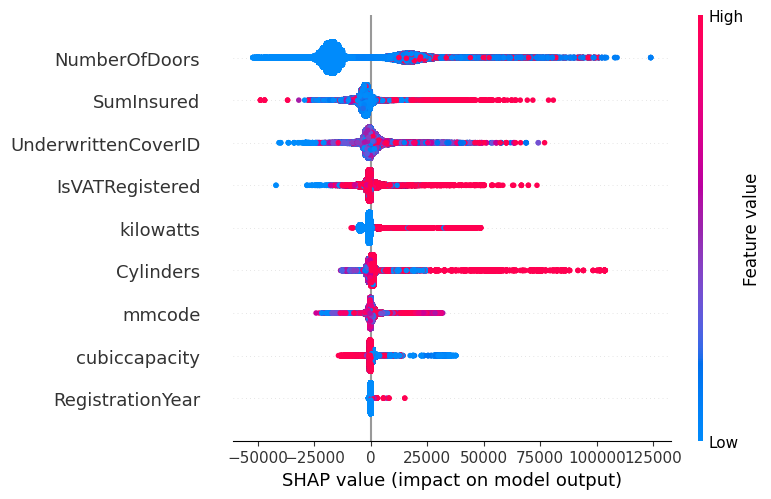

In [13]:
shap_values = model.shap_summary(X_test_np)
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns, max_display=10)